# Word, lemma, POS and character n-gram features

Import necessary packages 

In [156]:
import ast
import de_core_news_sm
import itertools
import matplotlib.pyplot as plt
from nltk import word_tokenize
import numpy as np
import pandas as pd
import pprint
from sklearn.ensemble import BaggingClassifier
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import spacy

Load data

In [157]:
df = pd.read_csv("01_Preprocessing_df.csv", sep="|", lineterminator = '\n')
df['Level_ABC'] = df.apply (lambda row: (row["Level"][0]),axis=1)

In [158]:
#create a colums for pos tags only
def get_tags_as_lst(rftagger):
    tags_as_lst = []
    for sent in ast.literal_eval(rftagger):
        for word in sent:                
            tags_as_lst.append(word[1])
    return tags_as_lst  

In [159]:
df['tagList'] = df.apply (lambda row: get_tags_as_lst(row["RFTagger"]),axis=1)

In [160]:
#create lemmatized column
nlp = de_core_news_sm.load()

def lemmatize(str):
    doc = nlp(str)
    return [tok.lemma_ for tok in doc]
    
df["Lemmas"] =  df.apply (lambda row: lemmatize(row["cleanedText"]),axis=1)

In [161]:
#create two dataframes for different sources
cleg = df[df.Source == "CLEG"]
cleg = cleg[cleg.Level_ABC.isin(["B","C"])]

b_c = df[df.Source != "CLEG"]
b_c = b_c[b_c.Level_ABC.isin(["B","C"])]

level = b_c.groupby("Level_ABC")
b_c = level.apply(lambda x: x.sample(level.size().min()).reset_index(drop=True))

level_cleg = cleg.groupby("Level_ABC")
cleg = level_cleg.apply(lambda x: x.sample(level_cleg.size().min()).reset_index(drop=True))

In [162]:
df = df[df.Level_ABC != "L"]
df = df[df.Type == "Writing"]
level = df.groupby('Level_ABC')
df = level.apply(lambda x: x.sample(level.size().min()).reset_index(drop=True))

Create vocabulary for the dataframe

In [163]:
def create_vocab(df):
    vocab = set()
    for row in df.iterrows():
        for item in word_tokenize(row[1]["cleanedText"]):
            vocab.add(item)
    return vocab

In [164]:
vocab = create_vocab(df)
print("Vocabulary size:", len(vocab))

Vocabulary size: 26239


# Get n-gram features

In [165]:
def get_ngram_features(df, vectorizer, column):  
    train, test = train_test_split(df, test_size=0.2)
    train_features = vectorizer.fit_transform([row[1][column] for row in train.iterrows()]).toarray() 
    ngram_feature_list = vectorizer.get_feature_names()
    test_features = vectorizer.transform([row[1][column] for row in test.iterrows()]).toarray()
    train_levels = [row[1]["Level_ABC"] for row in train.iterrows()]
    test_levels = [row[1]["Level_ABC"] for row in test.iterrows()]
    all_features = vectorizer.fit_transform([row[1][column] for row in df.iterrows()]).toarray()
    all_levels = [row[1]["Level_ABC"] for row in df.iterrows()]
    return train_features, train_levels, test_features, test_levels, ngram_feature_list, all_features, all_levels

In [166]:
def train_model(df, model, vectorizer, column):
    clf = model
    clf.fit(get_ngram_features(df, vectorizer, column)[0], get_ngram_features(df, vectorizer, column)[1])
    return clf

In [167]:
def return_cross_val_scores(df, model, get_features_function, vectorizer, column):
    clf = model
    if isinstance(df, pd.DataFrame):
        return cross_val_score(clf, get_features_function(df, vectorizer, column)[5], df["Level_ABC"], cv=10)
        
    else:
        return cross_val_score(clf, df[0], df[1], cv=10)

## Testing

* Word n-grams

In [168]:
for n in [10, 20, 50]:
    vectorizer = TfidfVectorizer(lowercase = False, ngram_range = (1,3), max_features = n)
    train_features, train_levels, test_features, test_levels, ngram_feature_list, all_features, all_levels = get_ngram_features(df, vectorizer, "cleanedText")
    scores = return_cross_val_scores((all_features, all_levels), SVC(), get_ngram_features, vectorizer, 'cleanedText')    
    print("Accuracy of", n, "word n-gram features:", (scores).mean(), "+-",(scores).std())

Accuracy of 10 word n-gram features: 0.7333557800224467 +- 0.03370779027822373
Accuracy of 20 word n-gram features: 0.7188215488215487 +- 0.023298325217995245
Accuracy of 50 word n-gram features: 0.732783389450056 +- 0.021667418800828703


In [169]:
for n in [100, 200, 500]:
    vectorizer = TfidfVectorizer(lowercase = False, ngram_range = (1,3), max_features = n)
    train_features, train_levels, test_features, test_levels, ngram_feature_list, all_features, all_levels = get_ngram_features(df, vectorizer, "cleanedText")
    scores = return_cross_val_scores((all_features, all_levels), SVC(), get_ngram_features, vectorizer, "cleanedText")    
    print("Accuracy of", n, "word n-gram features:", (scores).mean(), "+-",(scores).std())

Accuracy of 100 word n-gram features: 0.7158361391694725 +- 0.024887621675437472
Accuracy of 200 word n-gram features: 0.7212906846240179 +- 0.018728803010760534
Accuracy of 500 word n-gram features: 0.7291582491582492 +- 0.024025969692635957


In [170]:
for n in [1000, 2000, 5000]:
    vectorizer = TfidfVectorizer(lowercase = False, ngram_range = (1,3), max_features = n)
    train_features, train_levels, test_features, test_levels, ngram_feature_list, all_features, all_levels = get_ngram_features(df, vectorizer, "cleanedText")
    scores = return_cross_val_scores((all_features, all_levels), SVC(), get_ngram_features, vectorizer, "cleanedText")  
    print("Accuracy of", n, "word n-gram features:", (scores).mean(), "+-",(scores).std())

Accuracy of 1000 word n-gram features: 0.7346127946127947 +- 0.02560242438270276
Accuracy of 2000 word n-gram features: 0.7479573512906846 +- 0.02321741091697995
Accuracy of 5000 word n-gram features: 0.7516161616161616 +- 0.021881921485769874


In [171]:
for n in [10000]:
    vectorizer = TfidfVectorizer(lowercase = False, ngram_range = (1,3), max_features = n)
    train_features, train_levels, test_features, test_levels, ngram_feature_list, all_features, all_levels = get_ngram_features(df, vectorizer, "cleanedText")
    scores = return_cross_val_scores((all_features, all_levels), SVC(), get_ngram_features, vectorizer, "cleanedText")  
    print("Accuracy of", n, "word n-gram features:", (scores).mean(), "+-",(scores).std())

Accuracy of 10000 word n-gram features: 0.7564758698092031 +- 0.022007018366258305


* Character n-grams

In [172]:
for n in [10, 20, 50]:
    vectorizer = CountVectorizer(lowercase = False, analyzer = "char", ngram_range = (1,3), max_features = n)
    train_features, train_levels, test_features, test_levels, ngram_feature_list, all_features, all_levels = get_ngram_features(df, vectorizer, "cleanedText")
    scores = return_cross_val_scores((all_features, all_levels), SVC(), get_ngram_features, vectorizer, "cleanedText")   
    print("Accuracy of", n, "character n-gram features:", (scores).mean(), "+-",(scores).std())

Accuracy of 10 character n-gram features: 0.4050392817059484 +- 0.020188575773285145
Accuracy of 20 character n-gram features: 0.40198653198653195 +- 0.019752834530584563
Accuracy of 50 character n-gram features: 0.4214253647586981 +- 0.02313993732553663


In [173]:
for n in [100, 200, 500]:
    vectorizer = CountVectorizer(lowercase = False, analyzer = "char", ngram_range = (1,3), max_features = n)
    train_features, train_levels, test_features, test_levels, ngram_feature_list, all_features, all_levels = get_ngram_features(df, vectorizer, "cleanedText")
    scores = return_cross_val_scores((all_features, all_levels), SVC(), get_ngram_features, vectorizer, "cleanedText")  
    print("Accuracy of", n, "character n-gram features:", (scores).mean(), "+-",(scores).std())

Accuracy of 100 character n-gram features: 0.45177328843995507 +- 0.01969881139048882
Accuracy of 200 character n-gram features: 0.514915824915825 +- 0.024319951790585836
Accuracy of 500 character n-gram features: 0.5841301907968575 +- 0.024922103131120924


In [174]:
for n in [1000, 2000, 5000]:
    vectorizer = CountVectorizer(lowercase = False, analyzer = "char", ngram_range = (1,3), max_features = n)
    train_features, train_levels, test_features, test_levels, ngram_feature_list, all_features, all_levels = get_ngram_features(df, vectorizer, "cleanedText")
    scores = return_cross_val_scores((all_features, all_levels), SVC(), get_ngram_features, vectorizer, "cleanedText")  
    print("Accuracy of", n, "character n-gram features:", (scores).mean(), "+-",(scores).std())

Accuracy of 1000 character n-gram features: 0.6502693602693601 +- 0.03196279466555397
Accuracy of 2000 character n-gram features: 0.7194500561167227 +- 0.02358366548563007
Accuracy of 5000 character n-gram features: 0.8117620650953985 +- 0.01620588773597213


In [175]:
for n in [10000, 20000]:
    vectorizer = CountVectorizer(lowercase = False, analyzer = "char", ngram_range = (1,3), max_features = n)
    train_features, train_levels, test_features, test_levels, ngram_feature_list, all_features, all_levels = get_ngram_features(df, vectorizer, "cleanedText")
    scores = return_cross_val_scores((all_features, all_levels), SVC(), get_ngram_features, vectorizer, "cleanedText")    
    print("Accuracy of", n, "character n-gram features:", (scores).mean(), "+-",(scores).std())

Accuracy of 10000 character n-gram features: 0.8659034792368125 +- 0.025190586215732103
Accuracy of 20000 character n-gram features: 0.8810662177328844 +- 0.02162153661526683


* POS n-grams

In [176]:
for n in [10, 20, 50]:
    vectorizer = CountVectorizer(lowercase = False, ngram_range = (1,3), max_features = n, tokenizer = lambda text: text)
    train_features, train_levels, test_features, test_levels, ngram_feature_list, all_features, all_levels = get_ngram_features(df, vectorizer, "tagList")
    scores = return_cross_val_scores((all_features, all_levels), SVC(), get_ngram_features, vectorizer, "tagList")    
    print("Accuracy of", n, "POS n-gram features:", (scores).mean(), "+-",(scores).std())

Accuracy of 10 POS n-gram features: 0.5518855218855219 +- 0.026044353243728165
Accuracy of 20 POS n-gram features: 0.5573625140291807 +- 0.024604502373170824
Accuracy of 50 POS n-gram features: 0.6041414141414142 +- 0.01774129636108304


In [177]:
for n in [100, 200, 500]:
    vectorizer = CountVectorizer(lowercase = False, ngram_range = (1,3), max_features = n, tokenizer = lambda text: text)
    train_features, train_levels, test_features, test_levels, ngram_feature_list, all_features, all_levels = get_ngram_features(df, vectorizer, "tagList")
    scores = return_cross_val_scores((all_features, all_levels), SVC(), get_ngram_features, vectorizer, "tagList")       
    print("Accuracy of", n, "POS n-gram features:", (scores).mean(), "+-",(scores).std())

Accuracy of 100 POS n-gram features: 0.6380920314253647 +- 0.03096830518512908
Accuracy of 200 POS n-gram features: 0.7048709315375982 +- 0.027758814055307637
Accuracy of 500 POS n-gram features: 0.7838720538720538 +- 0.024808418054497107


In [178]:
for n in [1000, 2000, 5000]:
    vectorizer = CountVectorizer(lowercase = False, ngram_range = (1,3), max_features = n, tokenizer = lambda text: text)
    train_features, train_levels, test_features, test_levels, ngram_feature_list, all_features, all_levels = get_ngram_features(df, vectorizer, "tagList")
    scores = return_cross_val_scores((all_features, all_levels), SVC(), get_ngram_features, vectorizer, "tagList")     
    print("Accuracy of", n, "POS n-gram features:", (scores).mean(), "+-",(scores).std())

Accuracy of 1000 POS n-gram features: 0.8191694725028059 +- 0.034522278112311476
Accuracy of 2000 POS n-gram features: 0.83003367003367 +- 0.030219413254650745
Accuracy of 5000 POS n-gram features: 0.8354545454545456 +- 0.03641536724424892


In [179]:
for n in [10000]:
    vectorizer = CountVectorizer(lowercase = False, ngram_range = (1,3), max_features = n, tokenizer = lambda text: text)
    train_features, train_levels, test_features, test_levels, ngram_feature_list, all_features, all_levels = get_ngram_features(df, vectorizer, "tagList")
    scores = return_cross_val_scores((all_features, all_levels), SVC(), get_ngram_features, vectorizer, "tagList")      
    print("Accuracy of", n, "POS n-gram features:", (scores).mean(), "+-",(scores).std())

Accuracy of 10000 POS n-gram features: 0.8354545454545456 +- 0.03641536724424892


In [195]:
vectorizer = CountVectorizer(lowercase = False, tokenizer = lambda text: text)
train_features, train_levels, test_features, test_levels, ngram_feature_list, all_features, all_levels = get_ngram_features(df, vectorizer, "tagList")
scores = return_cross_val_scores((all_features, all_levels), SVC(), get_ngram_features, vectorizer, "tagList")      
print("Accuracy of all POS unigram features:", (scores).mean(), "+-",(scores).std())

Accuracy of all POS unigram features: 0.595016835016835 +- 0.018946867212433688


* Lemma n-grams

In [180]:
for n in [10, 20, 50]:
    vectorizer = TfidfVectorizer(lowercase = False, ngram_range = (1,3), max_features = n, tokenizer = lambda text: text)
    train_features, train_levels, test_features, test_levels, ngram_feature_list, all_features, all_levels = get_ngram_features(df, vectorizer, "tagList")
    scores = return_cross_val_scores((all_features, all_levels), SVC(), get_ngram_features, vectorizer, "Lemmas")    
    print("Accuracy of", n, "lemma ngram features:", (scores).mean(), "+-",(scores).std())

Accuracy of 10 lemma ngram features: 0.699337822671156 +- 0.0419161628589326
Accuracy of 20 lemma ngram features: 0.7339506172839505 +- 0.04529370470826846
Accuracy of 50 lemma ngram features: 0.7297194163860831 +- 0.036754416029756806


In [181]:
for n in [100, 200, 500]:
    vectorizer = TfidfVectorizer(lowercase = False, ngram_range = (1,3), max_features = n, tokenizer = lambda text: text)
    train_features, train_levels, test_features, test_levels, ngram_feature_list, all_features, all_levels = get_ngram_features(df, vectorizer, "tagList")
    scores = return_cross_val_scores((all_features, all_levels), SVC(), get_ngram_features, vectorizer, "Lemmas")    
    print("Accuracy of", n, "lemma ngram features:", (scores).mean(), "+-",(scores).std())

Accuracy of 100 lemma ngram features: 0.7193939393939394 +- 0.0424285712077264
Accuracy of 200 lemma ngram features: 0.7217845117845118 +- 0.051719637725298084
Accuracy of 500 lemma ngram features: 0.73337822671156 +- 0.04760442684674445


In [182]:
for n in [1000, 2000, 5000]:
    vectorizer = TfidfVectorizer(lowercase = False, ngram_range = (1,3), max_features = n, tokenizer = lambda text: text)
    train_features, train_levels, test_features, test_levels, ngram_feature_list, all_features, all_levels = get_ngram_features(df, vectorizer, "tagList")
    scores = return_cross_val_scores((all_features, all_levels), SVC(), get_ngram_features, vectorizer, "Lemmas")    
    print("Accuracy of", n, "lemma ngram features:", (scores).mean(), "+-",(scores).std())

Accuracy of 1000 lemma ngram features: 0.7400561167227835 +- 0.04598050855600795
Accuracy of 2000 lemma ngram features: 0.7455106621773289 +- 0.04380968250559622
Accuracy of 5000 lemma ngram features: 0.7479236812570147 +- 0.04366212815474028


# Visualization

In [183]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

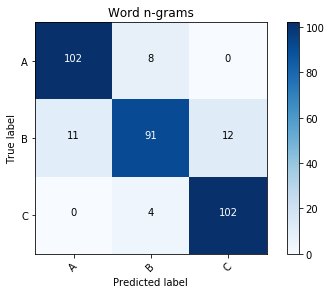

In [184]:
vectorizer = TfidfVectorizer(lowercase = False, ngram_range = (1,3), max_features = 5000)
train_features, train_levels, test_features, test_levels, ngram_feature_list_word, all_features, all_levels = get_ngram_features(df, vectorizer, "cleanedText")
clf_word = LinearSVC()
clf_word.fit(train_features, train_levels)
level_pred = clf_word.predict(test_features)

cnf_matrix = confusion_matrix(test_levels, level_pred)
class_names = ["A", "B", "C"]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Word n-grams')

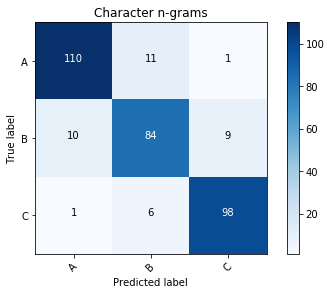

In [185]:
char_vectorizer = CountVectorizer(lowercase = False, ngram_range = (1,3), analyzer = "char", max_features = 20000)
train_features, train_levels, test_features, test_levels, ngram_feature_list, all_features, all_levels = get_ngram_features(df, char_vectorizer, "cleanedText")
clf_char = LinearSVC()
clf_char.fit(train_features, train_levels)
level_pred = clf_char.predict(test_features)

cnf_matrix = confusion_matrix(test_levels, level_pred)
class_names = ["A", "B", "C"]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Character n-grams')

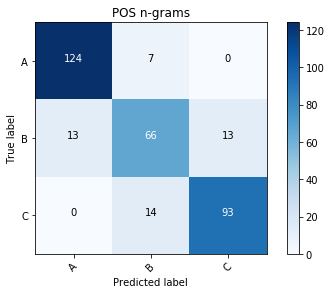

In [186]:
pos_vectorizer = CountVectorizer(lowercase = False, ngram_range = (1,3), max_features = 3000, tokenizer = lambda x:x)
train_features, train_levels, test_features, test_levels, ngram_feature_list, all_features, all_levels = get_ngram_features(df, pos_vectorizer, "tagList")
clf_pos = SVC()
clf_pos.fit(train_features, train_levels)
level_pred = clf_pos.predict(test_features)

cnf_matrix = confusion_matrix(test_levels, level_pred)
class_names = ["A", "B", "C"]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='POS n-grams')

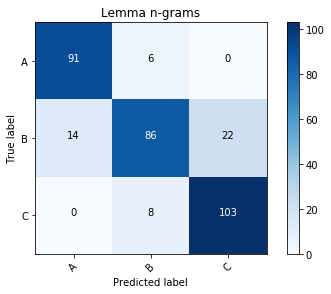

In [187]:
lem_vectorizer = CountVectorizer(lowercase = False, ngram_range = (1,3), max_features = 1000, tokenizer = lambda x:x)
train_features, train_levels, test_features, test_levels, ngram_feature_list, all_features, all_levels = get_ngram_features(df, lem_vectorizer, "Lemmas")
clf_lem = SVC()
clf_lem.fit(train_features, train_levels)
level_pred = clf_lem.predict(test_features)

cnf_matrix = confusion_matrix(test_levels, level_pred)
class_names = ["A", "B", "C"]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Lemma n-grams')

In [188]:
def plot_coefficients(classifier, feature_names, top_features=20):
    #function that plots the important coefficient for each class in a classifier
    #
    #param classifier:     classifier used
    #param feature_names:  list of feature names
    #param top_features:   numer of features on the graph
    #
    #return:               one graph for each class
    
    for stars, coef in enumerate([coefs.ravel() for coefs in classifier.coef_], start=1):
        top_positive_coefficients = np.argsort(coef)[-top_features:]
        top_negative_coefficients = np.argsort(coef)[:top_features]
        top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
        plt.figure(figsize=(15, 1))
        colors = ["red" if c < 0 else "blue" for c in coef[top_coefficients]]
        plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
        plt.title("Top features for categorizing level " + str(stars) + " texts")
        feature_names = np.array(feature_names)
        plt.xticks(np.arange(0, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha="right")
        plt.show()

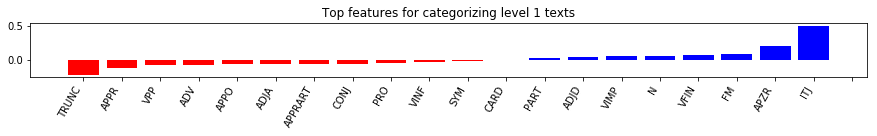

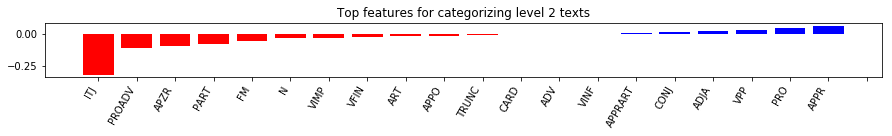

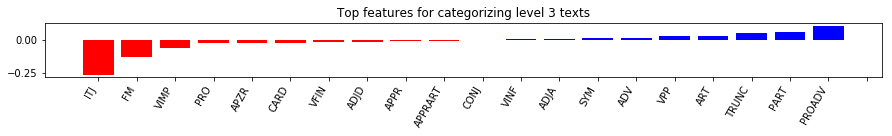

In [189]:
pos_vectorizer = CountVectorizer(lowercase = False, max_features = 1000, tokenizer = lambda x:x)
train_features, train_levels, test_features, test_levels, ngram_feature_list, all_features, all_levels = get_ngram_features(df,
                                                                                                pos_vectorizer, "tagList")
clf_pos = LinearSVC()
clf_pos.fit(train_features, train_levels)
level_pred = clf_pos.predict(test_features)

plot_coefficients(clf_pos, ngram_feature_list, top_features=10)

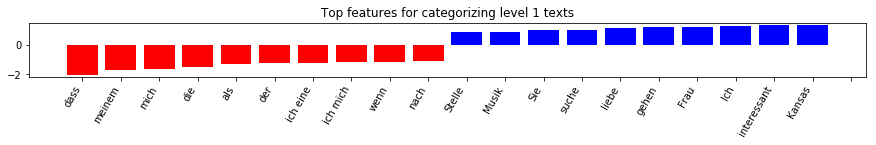

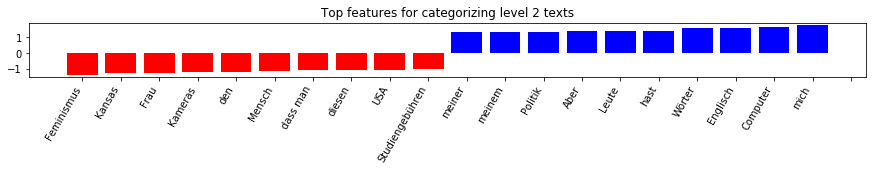

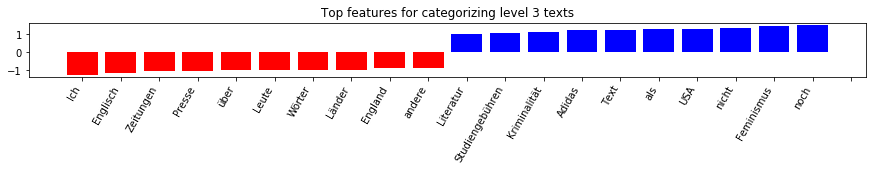

In [190]:
vectorizer = TfidfVectorizer(lowercase = False, max_features = 1000, ngram_range = (1,3))
train_features, train_levels, test_features, test_levels, ngram_feature_list, all_features, all_levels = get_ngram_features(df,
                                                                                                vectorizer, "cleanedText")
clf_word = LinearSVC()
clf_word.fit(train_features, train_levels)
level_pred = clf_word.predict(test_features)

plot_coefficients(clf_word, ngram_feature_list, top_features=10)

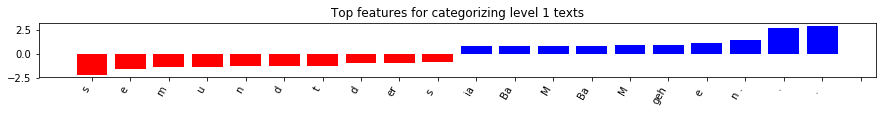

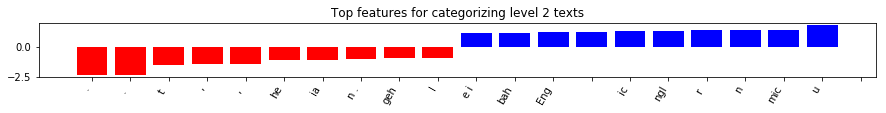

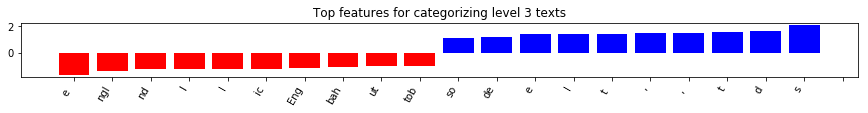

In [191]:
char_vectorizer = TfidfVectorizer(lowercase = False, analyzer = "char", max_features = 5000, ngram_range = (1,3))
train_features, train_levels, test_features, test_levels, ngram_feature_list, all_features, all_levels = get_ngram_features(df,
                                                                                                char_vectorizer, "cleanedText")
clf_char = LinearSVC()
clf_char.fit(train_features, train_levels)
level_pred = clf_char.predict(test_features)

plot_coefficients(clf_char, ngram_feature_list, top_features=10)

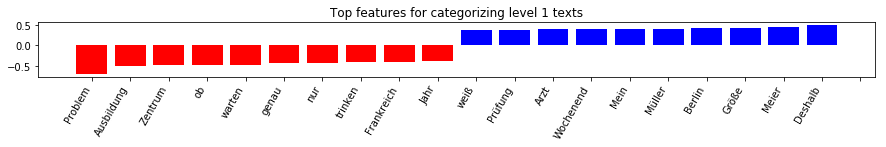

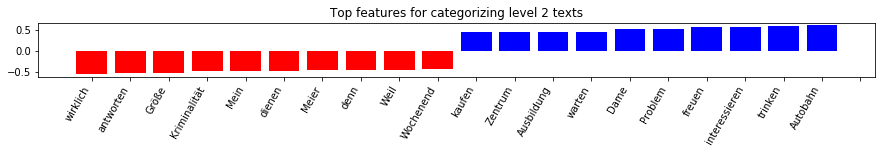

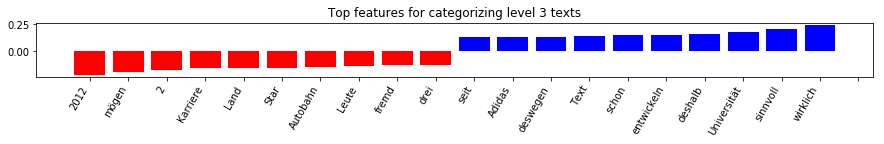

In [51]:
lem_vectorizer = CountVectorizer(lowercase = False, max_features = 1000, tokenizer = lambda x:x)
train_features, train_levels, test_features, test_levels, ngram_feature_list, all_features, all_levels = get_ngram_features(df,
                                                                                                lem_vectorizer, "Lemmas")
clf_lem = LinearSVC()
clf_lem.fit(train_features, train_levels)
level_pred = clf_lem.predict(test_features)

plot_coefficients(clf_lem, ngram_feature_list, top_features=10)

## Cross-dataset results

In [233]:
vectorizer = TfidfVectorizer(lowercase = False, max_features = 1000, ngram_range = (1,3))

train_features, train_levels, test_features, test_levels, ngram_feature_list, all_features, all_levels = get_ngram_features(b_c,
                                                                                                vectorizer, "cleanedText")

vocab = vectorizer.vocabulary_
vectorizer2 = TfidfVectorizer(lowercase = False, vocabulary = vocab)


train_features, train_levels, test_features, test_levels, ngram_feature_list, cleg_all_features, cleg_all_levels = get_ngram_features(cleg,
                                                                                                vectorizer2, "cleanedText")
clf_word = LinearSVC()
clf_word.fit(all_features, all_levels)
level_pred = clf_word.predict(cleg_all_features)

print("Accuracy of word n-grams trained on MERLIN+FALKO and tested on CLEG:", accuracy_score(level_pred, cleg_all_levels))

Accuracy of word n-grams trained on MERLIN+FALKO and tested on CLEG: 0.6603174603174603


In [238]:
char_vectorizer = CountVectorizer(lowercase = False, analyzer = "char", max_features = 20000, ngram_range = (1,3))

train_features, train_levels, test_features, test_levels, ngram_feature_list, all_features, all_levels = get_ngram_features(b_c,
                                                                                                char_vectorizer, "cleanedText")

vocab = char_vectorizer.vocabulary_
char_vectorizer2 = CountVectorizer(lowercase = False, analyzer = "char", vocabulary = vocab)

train_features, train_levels, test_features, test_levels, ngram_feature_list, cleg_all_features, cleg_all_levels = get_ngram_features(cleg,
                                                                                                char_vectorizer2, "cleanedText")
clf_char = SVC()
clf_char.fit(all_features, all_levels)
level_pred = clf_char.predict(cleg_all_features)

print("Accuracy of character n-grams trained on MERLIN+FALKO and tested on CLEG:", accuracy_score(level_pred, cleg_all_levels))

Accuracy of character n-grams trained on MERLIN+FALKO and tested on CLEG: 0.553968253968254


In [229]:
pos_vectorizer = CountVectorizer(lowercase = False, max_features = 5000, ngram_range = (1,3), tokenizer = lambda x : x)

train_features, train_levels, test_features, test_levels, ngram_feature_list, all_features, all_levels = get_ngram_features(b_c,
                                                                                              pos_vectorizer, "tagList")

vocab = pos_vectorizer.vocabulary_
pos_vectorizer2 = CountVectorizer(lowercase = False, vocabulary = vocab, tokenizer = lambda x : x)

train_features, train_levels, test_features, test_levels, ngram_feature_list, cleg_all_features, cleg_all_levels = get_ngram_features(cleg,
                                                                                                pos_vectorizer2, "tagList")
clf_pos = SVC()
clf_pos.fit(all_features, all_levels)
level_pred = clf_pos.predict(cleg_all_features)

print("Accuracy of POS n-grams trained on MERLIN+FALKO and tested on CLEG:", accuracy_score(level_pred, cleg_all_levels))

Accuracy of POS n-grams trained on MERLIN+FALKO and tested on CLEG: 0.6507936507936508


In [235]:
lem_vectorizer = CountVectorizer(lowercase = False, max_features = 5000, ngram_range = (1,3), tokenizer = lambda x : x)

train_features, train_levels, test_features, test_levels, ngram_feature_list, all_features, all_levels = get_ngram_features(b_c,
                                                                                                lem_vectorizer, "Lemmas")

vocab = lem_vectorizer.vocabulary_

lem_vectorizer2 = CountVectorizer(lowercase = False, vocabulary = vocab, tokenizer = lambda x : x)

train_features, train_levels, test_features, test_levels, ngram_feature_list, cleg_all_features, cleg_all_levels = get_ngram_features(cleg,
                                                                                                lem_vectorizer2, "Lemmas")
clf_lem = SVC()
clf_lem.fit(all_features, all_levels)
level_pred = clf_lem.predict(cleg_all_features)

print("Accuracy of lemma n-grams trained on MERLIN+FALKO and tested on CLEG:", accuracy_score(level_pred, cleg_all_levels))

Accuracy of lemma n-grams trained on MERLIN+FALKO and tested on CLEG: 0.6333333333333333
